In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import dgl
import dgl.function as fn
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torchmetrics
import tqdm
from captum.attr import IntegratedGradients
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import List

from sportsml.mongo import client
from sportsml.nba.data import NBAGraphDataset
from sportsml.nba.data.features import STATS_COLUMNS
from sportsml.nba.models import CatNNModel, GCNModel
from sportsml.nba.models.ptsdiff import PtsDiffModel

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RDKit is not installed, which is required for utils related to cheminformatics


In [3]:
plt.rcParams['figure.dpi'] = 250

In [4]:
games = pd.DataFrame(client.nba.games.find({}))

In [5]:
games = games[games['SEASON_ID'].astype(str).str.startswith('2')]

In [6]:
games['GAME_DATE_dt'] = pd.to_datetime(games['GAME_DATE'])

In [7]:
games['REST'] = games.sort_values('GAME_DATE').groupby(['SEASON_ID', 'TEAM_ID'])['GAME_DATE_dt'].transform('diff').dt.days

In [8]:
ds = NBAGraphDataset(games)

100%|██████████| 4101/4101 [01:14<00:00, 55.38it/s] 


In [9]:
feat_scaler = StandardScaler()
target_scaler = StandardScaler()
ds.games[STATS_COLUMNS] = feat_scaler.fit_transform(ds.games[STATS_COLUMNS].values)
ds.games[['PLUS_MINUS']] = target_scaler.fit_transform(ds.games[['PLUS_MINUS']].values)

In [10]:
train_ds, val_ds, test_ds = dgl.data.utils.split_dataset(ds, (0.8, 0.1, 0.1), shuffle=True, random_state=42)
train_dl = dgl.dataloading.GraphDataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_dl = dgl.dataloading.GraphDataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)
test_dl = dgl.dataloading.GraphDataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

In [11]:
ptsdiff_model = PtsDiffModel(
    feat_scaler=feat_scaler,
    target_scaler=target_scaler
)

In [12]:
trainer = pl.Trainer(logger=pl.loggers.CSVLogger('models', 'ptsdiff'))
ptsdiff_test_metrics = trainer.test(ptsdiff_model, test_dl)
np.sqrt(ptsdiff_test_metrics[0]['test_mse'])

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0:   1%|          | 3/282 [00:00<00:27, 10.13it/s]

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 i

Testing DataLoader 0: 100%|██████████| 282/282 [00:04<00:00, 59.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8932174444198608     │
│         test_mse          │    165.85043334960938     │
│          test_r2          │    0.09295386075973511    │
└───────────────────────────┴───────────────────────────┘

12.878293106992455

In [13]:
ptsdiff_preds = []
ptsdiff_targets = []
for g, lg in test_dl:
    p = ptsdiff_model(g, lg)
    p = ptsdiff_model.target_scaler.inverse_transform(p.detach().cpu().numpy())
    ptsdiff_preds.append(p)
    t = lg.edata['target'].detach().cpu().numpy()
    t = ptsdiff_model.target_scaler.inverse_transform(t)
    ptsdiff_targets.append(t)
ptsdiff_preds = np.vstack(ptsdiff_preds)
ptsdiff_targets = np.vstack(ptsdiff_targets)

In [14]:
(np.sign(ptsdiff_preds) == np.sign(ptsdiff_targets)).sum() / len(ptsdiff_preds)

0.6377767310409798

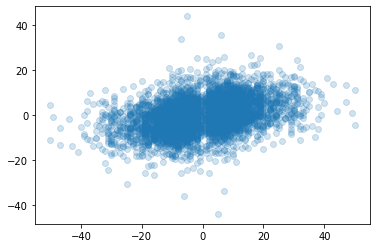

In [15]:
plt.scatter(ptsdiff_targets, ptsdiff_preds, alpha=0.2)
plt.show()

In [16]:
model = CatNNModel(feat_scaler=feat_scaler, target_scaler=target_scaler, hidden_feats=100)

In [17]:
trainer = pl.Trainer(
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        pl.callbacks.ModelCheckpoint(monitor='val_loss')
    ],
    logger=pl.loggers.CSVLogger('models', 'catnn')
)

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


  | Name | Type             | Params
------------------------------------------
0 | mse  | MeanSquaredError | 0     
1 | r2   | R2Score          | 0     
2 | nn   | Sequential       | 16.1 K
------------------------------------------
16.1 K    Trainable params
0         Non-trainable params
16.1 K    Total params
0.064     Total estimated model params size (MB)


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 i

Epoch 8: 100%|██████████| 2527/2527 [01:17<00:00, 32.70it/s, loss=0.798, v_num=9]


In [19]:
catnn_test_metrics = trainer.test(model, test_dl)
np.sqrt(catnn_test_metrics[0]['test_mse'])

Testing DataLoader 0:   3%|▎         | 9/282 [00:00<00:06, 39.10it/s]

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 i

Testing DataLoader 0: 100%|██████████| 282/282 [00:05<00:00, 47.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8144644498825073     │
│         test_mse          │    151.22772216796875     │
│          test_r2          │    0.17292630672454834    │
└───────────────────────────┴───────────────────────────┘

12.297468120225755

In [21]:
catnn_preds = []
catnn_targets = []
for g, lg in test_dl:
    p = model(g, lg)
    p = model.target_scaler.inverse_transform(p.detach().cpu().numpy())
    catnn_preds.append(p)
    t = lg.edata['target'].detach().cpu().numpy()
    t = model.target_scaler.inverse_transform(t)
    catnn_targets.append(t)
catnn_preds = np.vstack(catnn_preds)
catnn_targets = np.vstack(catnn_targets)

In [22]:
(np.sign(catnn_preds) == np.sign(catnn_targets)).sum() / len(catnn_preds)

0.6552048987282147

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


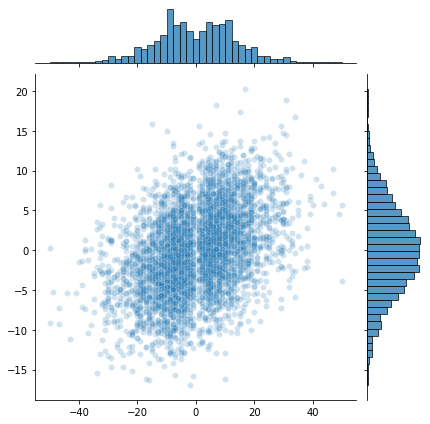

In [23]:
sns.jointplot(catnn_targets.reshape(-1), catnn_preds.reshape(-1), alpha=0.2)
plt.show()

In [ ]:
print(((scores>0) & (g.edata['y']>0)).sum() / (g.edata['y']>0).sum())
print(((scores>0) & (g.edata['y']>0)).sum() / (scores>0).sum())

print(((scores<0) & (g.edata['y']<0)).sum() / (g.edata['y']<0).sum())
print(((scores<0) & (g.edata['y']<0)).sum() / (scores<0).sum())

In [ ]:
print(r2_score(g.edata['y'], scores.detach().numpy()))
plt.scatter(g.edata['y'], scores.detach().numpy(), s=1)
plt.show()

In [ ]:
F.mse_loss(model(g, g.edata['x']), g.edata['y'])

In [ ]:
src = []
dst = []
for u in range(30):
    for v in range(30):
        if u == v:
            continue
        src.append(u)
        dst.append(v)

In [ ]:
complete_graph = dgl.graph((src, dst))
complete_graph.ndata['h'] = model.node_embedding(g, g.edata['x'])

In [ ]:
pred_edges = model.pred(complete_graph, complete_graph.ndata['h'])

In [ ]:
complete_graph.edata['pred'] = pred_edges

In [ ]:
complete_graph.edges[(g.node_idx['MIL'], g.node_idx['ATL'])]

In [ ]:
complete_graph = complete_graph.reverse(True, True)

In [ ]:
complete_graph.update_all(
    message_func=fn.copy_e('pred', 'pred_message'),
    reduce_func=fn.mean('pred_message', 'avg_pred')
)

In [ ]:
complete_graph = complete_graph.reverse(True, True)

In [ ]:
(complete_graph.edata['pred'][complete_graph.edge_ids(*complete_graph.out_edges(g.node_idx['PHX']))]>0)

In [ ]:
num_wins = [(complete_graph.edata['pred'][complete_graph.edge_ids(*complete_graph.out_edges(idx))]>0).sum().item() for idx in range(30)]
sorted([tup for tup in zip(g.node_names.values(), num_wins)], key=lambda x: -x[1])

In [ ]:
y_scaler.inverse_transform(complete_graph.ndata['avg_pred'].detach().numpy())

In [ ]:
u, v = complete_graph.edges()

In [ ]:
agg_scores = y_scaler.inverse_transform([pred_edges[u==idx].mean().item() for idx in range(30)])

In [ ]:
g.node_idx['UTA']

In [ ]:
sorted([tup for tup in zip(g.node_names.values(), agg_scores)], key=lambda x: -x[1])

In [ ]:
def team_draw(name):
    node_idx = g.node_idx[name]
    u, v = complete_graph.out_edges(node_idx)
    edge_ids = complete_graph.edge_ids(u, v)
    team_graph = dgl.graph((u, v))
    team_graph.edata['pred'] = complete_graph.edata['pred'][edge_ids]
    team_nx = team_graph.to_networkx(edge_attrs=['pred'])
    edge_color = [e['pred'].item() for u, v, e in team_nx.edges(data=True)]
    pos = nx.spring_layout(team_nx)
    edge_vmin = complete_graph.edata['pred'].min().item()
    edge_vmax = complete_graph.edata['pred'].max().item()
    nx.draw_networkx(team_nx, pos=pos, edge_color=edge_color, edge_cmap=plt.get_cmap('RdYlGn'), edge_vmin=edge_vmin, edge_vmax=edge_vmax, labels=g.node_names, node_size=500, node_color='white')
    edge_labels = {(u, v): round(e['pred'].item(), 2) for (u, v, e) in team_nx.edges(data=True)}
    nx.draw_networkx_edge_labels(team_nx, pos=pos, edge_labels=edge_labels, font_size=5)

In [ ]:
team_draw('OKC')